## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()[0]

290584

d. The proportion of users converted.

In [5]:
df['converted'].sum()/df['converted'].count()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('(group =="treatment" & landing_page =="old_page") or (group =="control" & landing_page =="new_page")').count()[0]

3893

f. Do any of the rows have missing values?

No Missing value.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('(group =="control" & landing_page =="old_page") or (group =="treatment" & landing_page =="new_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.groupby(['user_id']).count()['group'].sort_values(ascending = False).reset_index()['user_id'][0]

773192

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id ==773192].index

Int64Index([1899, 2893], dtype='int64')

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(2893,inplace = True)

C:\Users\nauetavo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.sum()/df2.converted.count()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_converted = df2.query('group == "control"')

p_control_convert = control_converted.converted.sum()/control_converted.converted.count()

p_control_convert

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_converted = df2.query('group == "treatment"')

p_treatment_convert = treatment_converted.converted.sum()/treatment_converted.converted.count()

p_treatment_convert

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page =="new_page"').count()[0]/df2.count()[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer**

There is no sufficient evidence to say that the new treatment page leads to more conversions because the different between the probability of control converted group and the probability of treatement converted group is small (0.120 vs 0.118).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**


H0: The convert rate of new page is less than or equal to the convert rate of old page **$p_{new}$** - **$p_{old}$** <= 0
    
H1: The convert rate of new page is more than the convert rate of old page **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.query('converted == 1').count()[0]/ df2.count()[0]

p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = p_new

p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]

n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query('group == "control"').shape[0]

n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([1,0], size =n_new, p = [p_new,(1-p_new)])
new_page_converted.mean()

0.12056981625490332

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted =  np.random.choice([1,0], size = n_old, p = [p_old, (1-p_old)])

old_page_converted.mean()

0.11793576276553272

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

0.002634053489370597

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
diffs = []

for _ in range(10000):
    
    new_page_converted = np.random.choice([1,0], size =n_new, p = [p_new,(1-p_new)])
    old_page_converted =  np.random.choice([1,0], size = n_old, p = [p_old, (1-p_old)])
    diff =  new_page_converted.mean() - old_page_converted.mean()
    diffs.append(diff)
    
p_diffs = np.array(diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  18.,  104.,  589., 1644., 2849., 2737., 1527.,  439.,   86.,
           7.]),
 array([-4.57247327e-03, -3.64810094e-03, -2.72372861e-03, -1.79935628e-03,
        -8.74983954e-04,  4.93883756e-05,  9.73760705e-04,  1.89813304e-03,
         2.82250537e-03,  3.74687769e-03,  4.67125002e-03]),
 <a list of 10 Patch objects>)

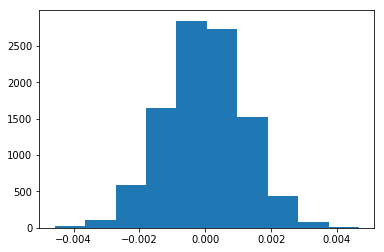

In [26]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
obs_diff = p_treatment_convert - p_control_convert

(p_diffs > obs_diff).mean()

0.9042

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**

This value called p-value. The smaller the number, the higher the possiblity to accept alternative hyphothesis. In this case, if this number less than 5%, we can recejt H0 and accept H1 which means The convert rate of new page is different from the convert rate of old page.

The p value calculated from j. is equal to 0.9098 which is higher than 0.05 (5%). It means we cannot reject H0. The convert rate of new page is not different from the convert rate of old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [50]:
import statsmodels.api as sm

convert_old = df2.query('(group =="control" & landing_page =="old_page" & converted ==1)').count()[0]
convert_new = df2.query('(group =="treatment" & landing_page =="new_page" & converted ==1)').count()[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

print("convert_old: {}, convert_new: {}, n_old: {}, n_new: {}".format(convert_old,convert_new,n_old,n_new))

convert_old: 17489, convert_new: 17264, n_old: 145274, n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [55]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])

print("two-sided test z_scrore: {}, p_value: {}".format(z_score, p_value))

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')

print("one-tailed test z_scrore: {}, p_value: {}".format(z_score, p_value))

two-sided test z_scrore: 1.3109241984234394, p_value: 0.18988337448195103
one-tailed test z_scrore: 1.3109241984234394, p_value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**

Since the z-score of 1.3109241984234394 stay within the critical value of 1.959963984540054, we can not reject null hyphothesis. The convert rate of new page is no different from the convert rate of old page.  

The same direction as the p-value, which is more than 0.05 (5%). We can not accept alternative hypothesis that the convert rate of new page is different from the convert rate of old page.


In part j and k, we have manually calculate z-score and p-value under the null hyphothesis of converted rate of new_page <= converted rate of old_page.
Using stat model, we have done 2 hyphothesis testing under "two-sides" testing and "one-tailed".Considering the one-tailed, the result from part j and k is in the same direction as calculated by stat model with p-value manual: 0.9042 vs p-value from stat model 0.905.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**

I chose Logistic regression because the answer we are looking for is either it's converted or not (binary vairable).

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

C:\Users\nauetavo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\nauetavo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

results = log_mod.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 08 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:57:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [32]:
np.exp(1/0.0150)

8.973574241179221e+28

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**Answer**

For each 1 unit decrease in ab_page, the convered will be 8.9 times as liky holding all else constant.

However, the result (p = 0.190) suggested that ab_page is statistically insignificat in predicting if the customer will convert when getting the new page.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer**

The p-value is equal to 0.19. There is no linear relationship between ab_page and conversion.

the result is different from the value in part II beacuase of different in hyphothesis setup.

In regression model, the hyphothesis testing is done on regression coefficients under two sides hyphothesis. The null hyphotheis is the true slope (beta) is equal to 0 (no linear relationship exist between x and y). While the alternative hyphosis is the beta !=0 (there is linear relationship between x and y)


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**

I think it's a good ideas to consider other factors in to the model such as country, consider users is male or female, ages of users etc.

Some disadvantages when add more variables in can be 

- need more time to prepare and clean information
- data can be highly correlated (multicollinearit effect)

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [34]:
df_new[['US','UK','CA']] = pd.get_dummies(df_new['country'])

df_new = df_new.drop('CA',axis = 1)

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [35]:
US = df_new.query('country =="US"')

US_convert_control = US.query('group =="control"')['converted'].sum()/ US.query('group =="control"').count()[0]

US_treatment_control = US.query('group =="treatment"')['converted'].sum()/ US.query('group =="treatment"').count()[0]

Diff_US = US_convert_control - US_treatment_control 

UK = df_new.query('country =="UK"')

UK_convert_control = UK.query('group =="control"')['converted'].sum()/ UK.query('group =="control"').count()[0]

UK_treatment_control = UK.query('group =="treatment"')['converted'].sum()/ UK.query('group =="treatment"').count()[0]

Diff_UK = UK_convert_control - UK_treatment_control 


CA = df_new.query('country =="CA"')

CA_convert_control = CA.query('group =="control"')['converted'].sum()/ CA.query('group =="control"').count()[0]

CA_treatment_control = CA.query('group =="treatment"')['converted'].sum()/ CA.query('group =="treatment"').count()[0]

Diff_CA = CA_convert_control - CA_treatment_control 


print("US convert {} vs US treatment {} Diff {}" .format(US_convert_control, US_treatment_control, Diff_US))
print("UK convert {} vs UK treatment {} Diff {}" .format(UK_convert_control, UK_treatment_control,Diff_UK))
print("CA convert {} vs CA treatment {} Diff {}" .format(CA_convert_control, CA_treatment_control, Diff_CA))

US convert 0.12062998938220143 vs US treatment 0.11846559963887227 Diff 0.002164389743329165
UK convert 0.12002200220022002 vs UK treatment 0.1211709965102753 Diff -0.0011489943100552735
CA convert 0.11878299527646569 vs CA treatment 0.11190247911245035 Diff 0.006880516164015332


**Answer**

Look at convert rate for all countries separate by control and treatement, the convert rate is not much different (less 1% for all countries).

It doesn't appear that country has any impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [57]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [58]:
df_new['US_ab_page'] = df_new ['US'] * df_new['ab_page']

df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']

log_mod = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK','US_ab_page','UK_ab_page']])

results = log_mod.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 08 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        14:13:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Answer**

Look at the statistical result, 

- P value for ab_page, US, UK, US_ab_page, and UK_ab_page are more than 0.05 (5%), and
- Z value are all appears in range between -1.96 / +1.96. (95% confident interval).

The result suggest that ab_page, countries (UK,US,CA), and interaction between page and country are statistically insignificat in predicting if the customer will convert when getting the new page.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.